# L'influence des promotions sur les ventes d'un supermarché 

Auteurs : Jarod Vanderlynden , Philippe Mathieu, [CRISTAL Lab](http://www.cristal.univ-lille.fr), [SMAC team](https://www.cristal.univ-lille.fr/?rubrique27&eid=17), [Lille University](http://www.univ-lille.fr), Romain Warlop, [fifty-five](https://www.fifty-five.com/fr/)

email : jarod.vanderlynden.etu@univ-lille.fr

Création : 5/12/2022


***
## Introduction

Cette feuille Jupyter décrit un exemple d'utilisation du modèle proposé dans l'article "_Comprendre l'impact des stratégies de prix sur le comportement des consommateurs_". 
Ce modèle permet notamment de construire un outil de simulation qui reproduit les faits marketings connus tout en en mesurant les impacts.
Ce notebook est en 3 parties, une première partie détaille le modèle et présente son fonctionnement. Une seconde partie présente les différentes possibilités d'utilisation du modèle et la dernière partie reprend les expériences qui ont été menés dans l'article.

## Présentation du modèle

Ce modèle représente un supermarché dans lequel on vend des biens de consommation courante. Les agents sont des abstractions des clients (une personne, une famille etc.) ayant chacun leurs propres paramètres internes (sensibilités). Les agents sont omniscients et connaissent tous les produits. Le modèle ne prend pas en compte la géographie du magasin ni l'emplacement des produits. 


In [1]:
from src.model import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### Les packs

Les promotions étudiées ici s'appuient sur la notion de pack ou de lots d'une même entité. Afin couvrir toutes les situations, l'ensemble de ce qui est vendu dans le supermarché est décrit par la notion de pack. La notion de pack est à comprendre au sens large : un pack peut être constitué d'un unique produit ou d'un produit répété plusieurs fois. On ne traite pas dans ce modèle de packs de produits différents.

Les packs sont des ensembles de biens de consommation simples, disposant de 5 caractéristiques : un prix, une qualité, une quantité, et un booléen de promotion. Ils sont identifiés par leur nom.

Ils sont instanciés via la classe `Pack(Nom,Prix,Qualité,Quantité)`. Le prix est un prix unitaire, la qualité un réel entre 0 et 1 , 0 représentant une qualité médiocre et 1 représentant la meilleure qualité possible, la quantité le nombre d'unités présentes dans le pack. La quantité de produit fait référence au nombre de produits unitaires dans le pack. Pour des raisons de simplicité, nous ne modélisons pas le volume d'un produit (en gramme, en ml, etc.). Quand un pack est initialement créé, la promotion est mise à `False`, c'est pourquoi elle n'est pas dans le constructeur. Le produit n'est pas modélisé en tant que tel.


In [3]:
# un pack de 2 paquets de pâtes
p0 = Pack("Pâtes de marque X", 2.3, 0.5, 2)

# une seule bouteille de shampoing de qualité
p1 = Pack("Un shampoing de marque X", 18.0, 1.0, 1)

# un lot 4 shampoings de moyenne gamme
p2 = Pack("Lot shampoing de marque Y", 5.0, 0.5, 4)


Le pack `p0` est un pack de 2 produits, au prix unitaire de `2.3`, ce qui donne un prix global pour le pack de 4.6.

In [4]:
p0.getPriceUnit(),p0.getTotalPrice()

(2.3, 4.6)

Pour plus de réalisme les packs sont répartis en différentes catégories. Une catégorie représente des produits comparables entre eux. Dans ce modèle un client ne choisira qu'un seul pack dans une catégorie donnée (un pack d'eau de 6 bouteilles, dans la catégorie "eaux" par ex).

Une catégorie est instanciée avec `Category(nom,liste de packs)`. La création d'une catégorie nécessite une liste de packs. Cette liste de packs peut être initialement vide, on ajoutera alors les packs au fur et à mesure à l'aide de la méthode `add_pack(pack)`. 

In [5]:
# les pates
cat1 = Category("pates",[p0])
cat1.showPacks()

Nom :  Pâtes de marque X , Prix total :  4.6


0

In [6]:
# les shampoings
cat2 = Category("shampoing",[])
cat2.addPack(p1)
cat2.addPack(p2)
cat2.showPacks()

Nom :  Lot shampoing de marque Y , Prix total :  20.0
Nom :  Un shampoing de marque X , Prix total :  18.0


0

- Un pack donne accès à plusieurs méthodes dont ``getName(),getTotalPrice(),simplePromotion(percent)``, percent étant le pourcentage de réduction à appliquer au produit lors d'une promotion.
- Une catégorie donne accès à plusieurs méthodes dont ``addPack(pack), getPacks(), showPacks()``

### Le SMA

L'environnement correspond au supermarché. On ne s'interesse pas dans ce modèle au placement géographique des packs, et les agents sont omniscients. Il n'est donc pas necessaire de représenter explicitement l'environnement.
Le SMA est donc constitué uniquement des agents et de la liste des packs étudiés. Afin de l'instancier on lui fournit une liste de catégories qui elles-mêmes contiennent les packs. 
Un magasin plus complet devrait idéalement contenir plusieurs catégories contenant plusieurs packs. Le modèle est capable de traiter plusieurs catégories simultanément, mais dans cet exemple nous restons à une seul catégorie pour illustrer nos résultats.
Le SMA est instancié avec `SMA(list_cat[cat1,cat2,...],nb_agent,nb_ticks)`, `list_cat` étant une liste de catégorie, `nb_agent` le nombre d'agents, et `nb_ticks` le nombre de pas de temps de simulation que nous souhaitons réaliser. Un tick correspond au fait que tous les agents vont 1 fois au suermarché (on pourrait considérer que c'est 1 semaine).

Dans ce modèle simplifié, nous partons du principe que les packs sont disponibles en quantité infinie. Il n'y a donc pas de quantité en stock ni de rupture de stock. 

Le paramètre `nb_agents` génère `n` agents dont les caractéristiques sont aléatoires (besoins, sensibilités etc ...).


In [7]:
# Création du SMA sans aucun agent
monSMA = SMA([cat1,cat2],0,10)

In [8]:
monSMA.initialise()

0

Il n'y a pour l'instant encore aucun agent. Si la simulation est lancée maintenant, bien évidemment rien ne se passe.
L'attribut `revenus` permet d'obtenir le chiffre d'affaire du magasin à chaque pas de temps de simulation.
Nous avons indiqué précédemment notre souhait d'avoir 10 tours de parole, si on execute le SMA, on obtient alors 10 valeurs, pour l'instant toutes à zero puisqu'il n'y a personne.

In [9]:
monSMA.run()
monSMA.getTurnover()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Les agents

Les agents représentent les clients. Un client possède ses propres caractéristiques (sensibilités) et réalise des choix en conséquence durant son processus d'achat. 
Il est instancié via la classe `Agent(nom, SMA, hLength, Historique, Profil)`. SMA référence le système dans lequel l'agent évolue. Historique, l_historique et profil sont des paramètres optionnels (aléatoires si non précisés et hLength à 50). `hLength` représente la taille maximale de l'historique d'un agent en fenêtre glissante (les n derniers achats). 

In [9]:
# Cet agent dispose d'un historique d'achats et d'un profil tirés aléatoirement. 
a1 = Agent("Mon 1er agent",monSMA,hLength = 20)

#### Les profils / sensibilités
Afin d'avoir une différentiation comportementale entre les agents, chacun est doté d'un profil spécifique. Dans ce modèle, le profil d'un agent caractérise les sensibilités de celui ci: Il est constitué d'une map de 4 clés `Prix`, `Qualité`, `Inertiel` `Promophile`, associées à des valeurs de type pourcentage totalisant 100%. Certains agents accordent plus d'importance au prix, ils correspondent aux clients à petit budget. A l'inverse certains agents accordent beaucoup d'importance à la qualité, ils correspondent aux clients qui disposent d'un gros budget, achetant les produits de bonne qualité. Les promophiles sont sensibles aux promotions, les inertiels fidèles à une marque. Quand toutes ces variables sont à peu près équivalentes on parlera de profil équilibré. Dans ce cas les clients accordent une importance à peu près similaire à toutes les caractéristiques des produits. 

In [10]:
# Création d'un profil sensible aux promotions et aux prix 
profil1 = Profil({'inertia': 0.03,'price': 0.46,'quality': 0.05,'promophile': 0.46})
profil1.getProfil()

{'inertie': 0.03, 'price': 0.46, 'quality': 0.05, 'promophile': 0.46}

In [12]:
# Création d'un profil sensible à la qualité et loyal
profil2 = Profil({'price': 1,'quality': 20,'inertia': 20,'promophile': 1})
profil2.getProfil()

{'inertie': 0.47619047619047616,
 'price': 0.023809523809523808,
 'quality': 0.47619047619047616,
 'promophile': 0.023809523809523808}

Le profil peut être affecté à un agent à sa création 

In [17]:
a2 = Agent("Agent 2", monSMA, profil=profil1)
print(a2.name, ':' , a2.getProfil())

a3 = Agent("Agent 3", monSMA, profil=profil2)
print(a3.name , ':' , a3.getProfil() )

Agent 2 : {'inertie': 0.03, 'price': 0.46, 'quality': 0.05, 'promophile': 0.46}
Agent 3 : {'inertie': 0.47619047619047616, 'price': 0.023809523809523808, 'quality': 0.47619047619047616, 'promophile': 0.023809523809523808}


Il est aussi possible de créer directeur un agent avec un profil aléatoire. Dans ce cas, le tirage n'est pas uniforme mais met toujours en évidence l'une des 4 caratéristiques, sauf pour le profil équilibré.

In [18]:
# initialisation d'un profil aléatoire
a4 = Agent("Agent 4",monSMA)
a4.getProfil()

{'inertie': array([0.26823902]),
 'price': array([0.25071446]),
 'quality': array([0.28519384]),
 'promophile': array([0.19585268])}

### L'historique

L'historique représente les derniers achats d'un agent par catégorie. Cet historique est une map avec comme clés les nom de catégories et comme valeurs la liste des packs achetés par cet agent (avec la quantité de packs achetée). 



In [19]:
#L'historique généré aléatoirement des agents que nous avons crées. 
a1.getHistory()

{'pates': [(Pâtes de marque X, 8),
  (Pâtes de marque X, 7),
  (Pâtes de marque X, 4),
  (Pâtes de marque X, 2),
  (Pâtes de marque X, 3),
  (Pâtes de marque X, 4),
  (Pâtes de marque X, 2),
  (Pâtes de marque X, 3),
  (Pâtes de marque X, 3),
  (Pâtes de marque X, 2),
  (Pâtes de marque X, 2),
  (Pâtes de marque X, 4),
  (Pâtes de marque X, 7),
  (Pâtes de marque X, 5),
  (Pâtes de marque X, 3),
  (Pâtes de marque X, 2),
  (Pâtes de marque X, 3),
  (Pâtes de marque X, 3),
  (Pâtes de marque X, 4),
  (Pâtes de marque X, 6)],
 'shampoing': [(Un shampoing de marque X, 11),
  (Lot shampoing de marque Y, 8),
  (Un shampoing de marque X, 11),
  (Un shampoing de marque X, 6),
  (Lot shampoing de marque Y, 4),
  (Un shampoing de marque X, 3),
  (Un shampoing de marque X, 8),
  (Lot shampoing de marque Y, 9),
  (Un shampoing de marque X, 9),
  (Un shampoing de marque X, 2),
  (Un shampoing de marque X, 11),
  (Un shampoing de marque X, 6),
  (Lot shampoing de marque Y, 5),
  (Lot shampoing de m

Pour créer un historique il y a 2 manières de faire : soit passer par une méthode  `genHistory(cat_list, avg, length)` soit passer directement la liste à un agent `History (dict{catégorie1:achats,...},dict{catégorie1:quantité,....})`. La première méthode génère un historique à partir de la liste des catégories et de la moyenne associée. La seconde nécessite un historique complet. 

In [20]:
H = genHistory([cat1,cat2],[10,5],50)

In [21]:
a5 = Agent("Agent 5",monSMA,history = H)
a5.getHistory()

{'pates': [(Pâtes de marque X, 7),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 8),
  (Pâtes de marque X, 8),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 8),
  (Pâtes de marque X, 7),
  (Pâtes de marque X, 10),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 7),
  (Pâtes de marque X, 10),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 8),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 7),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 7),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 10),
  (Pâtes de marque X, 8),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 8),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 10),
  (Pâtes de marque X, 8),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 11),
  (Pâtes de ma

Ajoutons ces 3 agents à notre environnement en prenant garde à bien passer une liste en paramètre.

In [22]:
monSMA.addAgent([a1,a2,a3,a4,a5])

### La simulation

Nous disposons maintenant de tout ce dont nous avons besoin pour réaliser une simulation. La simulation peut être lancée plusieurs fois, un résultat différent apparaîtra à cause de l'aspect stochastique du modèle notamment dans le choix des agents (l'agent choisit un produit d'une catégorie selon une loi de probabilité proportionnelle au score du produit). 

In [23]:
monSMA.initialise()
monSMA.run()
monSMA.getTurnover()

array([568.2, 180.8, 749. , 924.6, 298. , 640.6,  84.4, 947. , 773.2,
       361.6])

La liste affichée présente l'évolution du chiffre d'affaires à chaque pas de temps pour l'ensemble les agents $Sum(produits achetés * quantité acheté * prix)$.
Pour mieux comprendre les mécanismes du modèle il est possible d'afficher une trace de ce que les agents ont acheté.

Ici nous avons enregistré 5 agents qui achètent dans 2 catégories (donc 2 packs).

In [24]:
monSMA.initialise()
monSMA.run(trace=True)
monSMA.getTurnover()

Pas de temps num :  0  Agent :  Mon 1er agent  Besoin 3.75  Achat :  Pâtes de marque X Quantité :  2
Pas de temps num :  0  Agent :  Mon 1er agent  Besoin 5.55  Achat :  Un shampoing de marque X Quantité :  6
Pas de temps num :  0  Agent :  Agent 2  Besoin 7.32  Achat :  Pâtes de marque X Quantité :  4
Pas de temps num :  0  Agent :  Agent 2  Besoin 6.2  Achat :  Lot shampoing de marque Y Quantité :  2
Pas de temps num :  0  Agent :  Agent 3  Besoin 3.44  Achat :  Pâtes de marque X Quantité :  2
Pas de temps num :  0  Agent :  Agent 3  Besoin 7.26  Achat :  Un shampoing de marque X Quantité :  7
Pas de temps num :  0  Agent :  Agent 4  Besoin 7.48  Achat : Rien Quantité : 0
Pas de temps num :  0  Agent :  Agent 4  Besoin 8.2  Achat :  Un shampoing de marque X Quantité :  12
Pas de temps num :  0  Agent :  Agent 5  Besoin 9.18  Achat :  Pâtes de marque X Quantité :  6
Pas de temps num :  0  Agent :  Agent 5  Besoin 5.02  Achat : Rien Quantité : 0
Pas de temps num :  1  Agent :  Mon 1er 

array([ 554.4,  176.2,  860.8,  539. ,  852.2,  336. ,  262. ,  938.8,
        335.2, 1031.2])

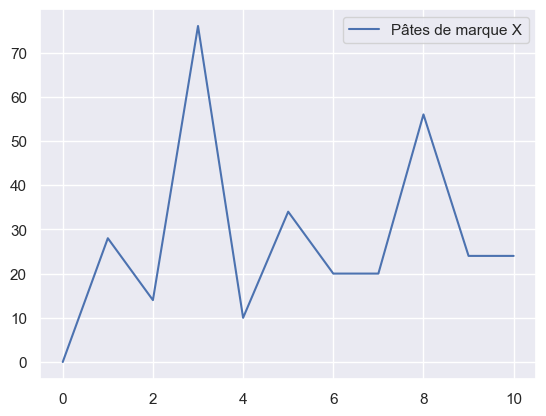

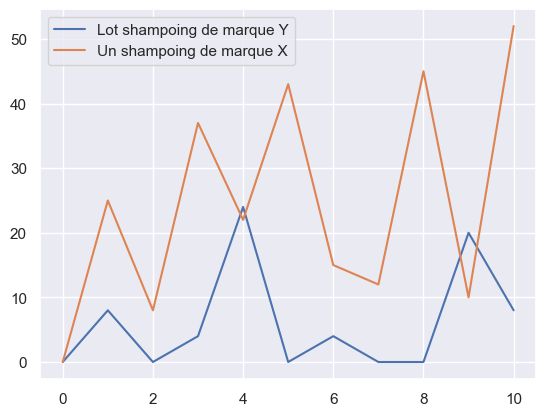

0

In [25]:
# Pour afficher les ventes de chaque packs
# Il trace automatiquement autant de graphiques qu'il y a de catégories
monSMA.showPacksSales()

La méthode `initialise` permet de relancer une simulation. Une réinitialisation du SMA ne change pas les historiques des agents. Cela ne réinitialise que les paramètres du SMA (ce qui a déjà été acheté).

Après `initialize` les agents poursuivent la nouvelle exépience avec les profils et historiques d'achats de la simulation précédente.

***
## Utilisation du modèle pour les promotions

### La promotion
Maintenant que nous avons nos agents différentiés, chacun avec son propre profil (dont des promophiles) Il est possible d'étudier l'influence de différentes promotions. L'application d'une promotion se fait par la méthode `makePromo(type,quantity,ticks,category,pack)`.

`type` est le type de promotion. (0 de type pourcentage de réduction, 1 de type x acheté y offert)

`quantity` le pourcentage de la promotion (si c'est une promotion en %) ou un doublet (x,y) si c'est une promotion x acheté y offert.

`ticks` un doublet contenant 2 entiers, le pas de temps du début de la promotion et le pas de temps de fin de promotion. 

`category` Le nom de la catégorie sur laquelle on souhaite faire une promotion

`pack` Le nom du pack sur lequel on souhaite faire une promotion


In [38]:
# Reprenons un modèle complet

# Les produits
base_price = np.random.randint(10, 100)
packs = []
for j in range(3):
    price = base_price + np.random.normal(0,(base_price/4))   # On tire un prix de base aléatoire
    quality = np.random.normal((price/100),0.1)               # On tire une qualité proportionelle au prix
    for i in range(3):                                        # Création de 3 produits qu'on considerera d'une même marque (même qualité)
        packs.append(Pack(("Produit" + str(i+(j*3))), price, np.absolute(quality), 2 * (i+1)))
        price = price * 0.9                                   # On estime que le prix à l'unité est plus bas sur les produits vendu en grand quantité

# les catégories
Ma_categorie = Category("maCategorie", packs)

# On fait 300 pas de temps de simulation et on indique au sma de créer lui même aléatoirement 100  (à profils équitablement répartis sur les 5 possibles).
testSMA = SMA([Ma_categorie],300,100) 

In [39]:
# On lance ici le SMA sur 100 étapes, avec une promotion entre les ticks 30 et 34
testSMA.initialise()
testSMA.makePromo(0,40,(30,34),"maCategorie","Produit0")
testSMA.run()

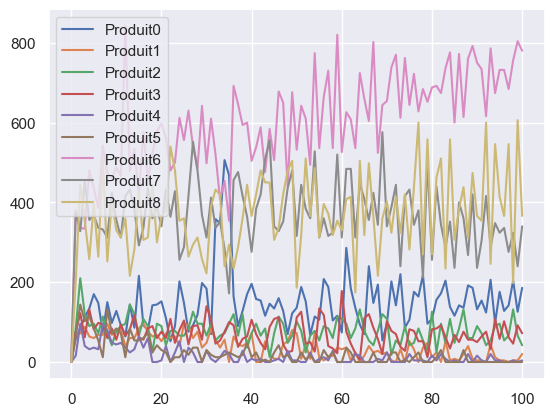

0

In [41]:
# Affichage des ventes par produit
# On voir bien le pic de ventes sur le produit 0 un peu après 34
testSMA.showPacksSales()

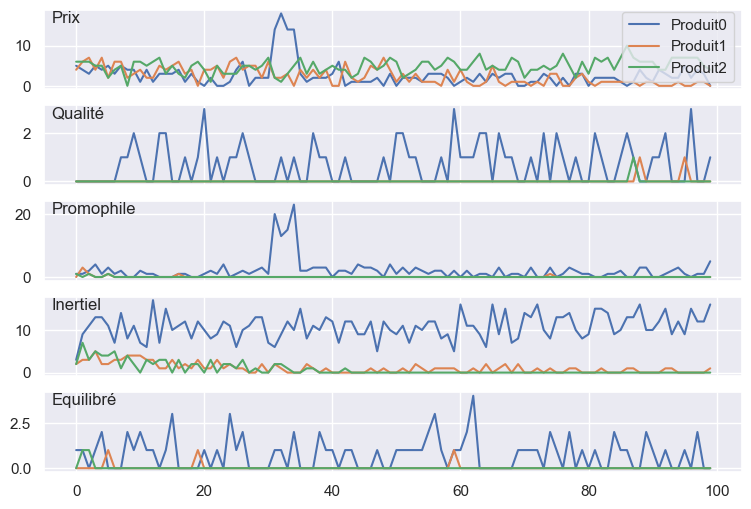

In [43]:
#Affichage du nombre d'acheteurs des 3 premiers produit selon leur profil
# On remarque toujours vers l'étape 35 un pic d'acheteurs du produit0 issu des agents prix et promophiles
testSMA.showProfileSales()

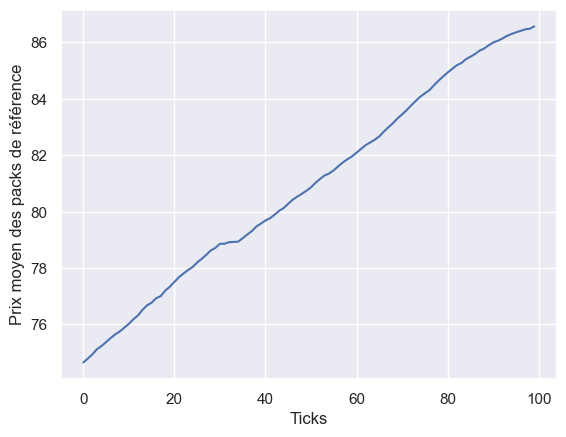

In [30]:
# Affichage du prix de référence moyen
testSMA.showMeanNeeds()

On remarque que certains packs sont plus populaires que d'autre notamment les packs de petite quantité. En effet même si ils sont plus chers ils correspondent au besoins d'un plus grand nombre d'agents. 

On observe sur cette simulation que le produit 0, qui est le produit en promotion, voit une forte augmentation de ses ventes durant la promotion. 
Afin de pouvoir observer l'impact des promotions plus préciséments nous allons comparer une même simulation avec et sans promotion. 

***
## Article

Dans cette partie nous reproduisons la plupart des résultats des expérimentations de l'article _"Comprendre l'impact des stratégies de prix sur le comportement des consommateurs"_

### L’augmentation du volume des ventes

In [27]:
#Figure1 : une exp classique sans promotion
drevenues = {}
dproducts = {}
for i in range(20):
    print(i,end=" ")
    np.random.seed(0)
    test = generate_pack_categorie("bananes") # Création de la catégorie de packs
    sma = SMA([test],300,100)
    sma.initialise()
    np.random.seed(int(10000 * time.time()) % 2**32)
    sma.run()
    drevenues[i] = sma.revenues
    j=0
    for pack in sma.packs_categories[0].pack_list:  #Cette ligne ne fonctionne qu'avec une seule catégorie. 
        if not j in dproducts.keys():
            dproducts[j] = {}
        dproducts[j][i] = sma.cumulative_nb_bought_per_pack[pack.name]
        j+=1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [28]:
#Figure2 : la même experience, mais avec une promotion de 40% des prix
drevenues2 = {}
dproducts2 = {}
for i in range(20):
    print(i,end=" ")
    np.random.seed(0)
    test = generate_pack_categorie("bananes") # Création de la catégorie de packs
    sma2 = SMA([test],300,100)
    sma2.initialise()
    sma2.makePromo(0,40,(30,34),"bananes","bananes0")
    np.random.seed(int(10000 * time.time()) % 2**32)
    sma2.run()
    drevenues2[i] = sma.revenues
    j=0
    for pack in sma2.packs_categories[0].pack_list:  #Cette ligne ne fonctionne qu'avec une seule catégorie. 
        if not j in dproducts2.keys():
            dproducts2[j] = {}
        dproducts2[j][i] = sma2.cumulative_nb_bought_per_pack[pack.name]
        j+=1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [45]:
# Code nécessaire au cumul des experiences pour tracer les courbes

# fig, axs = plt.subplots(1,2, figsize=(15, 4))
for key in dproducts.keys():
    df = pd.DataFrame(data = dproducts[key])
    df['moy']= df.mean(axis=1)
    df['ecart']= df.std(axis=1)
    new_color =  plt.plot(df.index , df.moy, linewidth=2, linestyle='-',
    label='exp')[0].get_color()
    plt.fill_between(df.index,df.moy-(df.ecart), df.moy+(df.ecart),
    color=new_color, alpha=0.2)
plt.ylabel("Quantité vendu")
plt.xlabel("Ticks")
plt.savefig("NbAcheteurs0.svg",bbox_inches='tight')
plt.show()


for key in dproducts2.keys():
    df = pd.DataFrame(data = dproducts2[key])
    df['moy']= df.mean(axis=1)
    df['ecart']= df.std(axis=1)
    new_color = plt.plot(df.index , df.moy, linewidth=2, linestyle='-',
    label='exp')[0].get_color()
    plt.fill_between(df.index,df.moy-(df.ecart), df.moy+(df.ecart),
    color=new_color, alpha=0.2)
plt.ylabel("Quantité vendu")
plt.xlabel("Ticks")
plt.axvspan(31, 35, alpha=0.2, color='red')
# plt.savefig("NbAcheteurs1.svg",bbox_inches='tight')
# plt.savefig("VolumeDesVentes.svg")

NameError: name 'dproducts' is not defined

Sur cette figure pour une réduction de 40% du prix, nous observons en moyenne une augmentation de 50% du volume des ventes sur le produit en promotion.

### Impact des promotions répétées

Nous proposons de réaliser 3 simulations.

-Sans promotion

-Avec 5 promotions successives à 20%

-Avec 5 promotions successives à 50%

In [30]:
def my_plot(df):
    df['moy']= df.mean(axis=1)
    df['ecart']= df.std(axis=1)
    plt.plot(df.index ,df.moy)
    plt.fill_between(df.index ,df.moy-(df.ecart), df.moy+(df.ecart),alpha=0.2)
    return 0

In [31]:
dfmeanPrice1 = pd.DataFrame()
dfmeanPrice2 = pd.DataFrame()
dfmeanPrice3 = pd.DataFrame()
#Nombre d'expériences à réaliser 
for i in range(20):
    print(i, end=' ')
    
    # Création des SMA
    np.random.seed(3)
    test = generate_pack_categorie("bananes") # Création de la catégorie de packs
    sma1 = SMA([test],300,100)
    sma1.initialise()
    sma2 = SMA([test],300,100)
    sma2.initialise()
    sma3 = SMA([test],300,100)
    sma3.initialise()

    # Promotions
    sma2.makePromo(0,20,(10,14),"bananes","bananes0")
    sma2.makePromo(0,20,(20,24),"bananes","bananes0")
    sma2.makePromo(0,20,(30,34),"bananes","bananes0")
    sma2.makePromo(0,20,(40,44),"bananes","bananes0")
    sma2.makePromo(0,20,(50,54),"bananes","bananes0")

    sma3.makePromo(0,50,(10,14),"bananes","bananes0")
    sma3.makePromo(0,50,(20,24),"bananes","bananes0")
    sma3.makePromo(0,50,(30,34),"bananes","bananes0")
    sma3.makePromo(0,50,(40,44),"bananes","bananes0")
    sma3.makePromo(0,50,(50,54),"bananes","bananes0")

    # Simulations
    np.random.seed(int(10000 * time.time()) % 2**32)
    sma1.run()
    sma2.run()
    sma3.run()
    
    #Enregistrement des résultats
    for cat in sma1.packs_categories:
        dfmeanPrice1.insert(i,cat.name+str(i),sma1.getMeanNeeds()[cat.name])
        dfmeanPrice2.insert(i,cat.name+str(i),sma2.getMeanNeeds()[cat.name])
        dfmeanPrice3.insert(i,cat.name+str(i),sma3.getMeanNeeds()[cat.name])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

[]

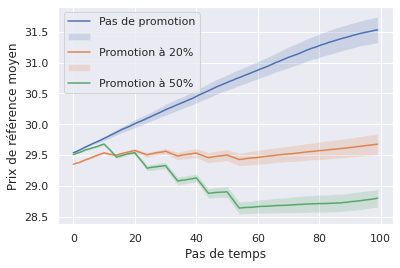

In [32]:
#Affichage
#Comme on a qu'une seul catégorie l'affichage est plus simple
my_plot(dfmeanPrice1)
my_plot(dfmeanPrice2)
my_plot(dfmeanPrice3)
plt.legend(["Pas de promotion","","Promotion à 20%","","Promotion à 50%"])
plt.ylabel("Prix de référence moyen")
plt.xlabel("Pas de temps")
plt.savefig("PrixRefMoyen.svg",bbox_inches='tight')
plt.plot()

### L’acquisition et la rétention de nouveaux clients

In [33]:
np.random.seed(3)
test = generate_pack_categorie("bananes")
sma = SMA([test],300,100)
sma.initialise()
sma.makePromo(0,40,(30,34),"bananes","bananes0")
sma.run()

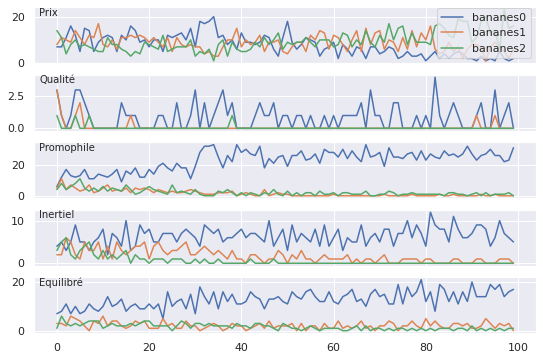

In [34]:
sma.showProfileSales()

On observe que les agents promophiles sont plus impactés par la promotion que les autres agents. De plus on observe une fidélisation sur certains profils. 

### Guerre des prix

On génère 2 produits assez similaires, l'un porté sur la qualité, l'autre sur le prix. On peut aussi imaginer deux produits très différents en terme de prix/qualité ou encore 2 produits encore plus similaires. Ces caractéristiques auront un impact sur les courbes que nous allons observer. Le but ici est de présenter une guerre des prix, avec des baisses successives du prix des produits. 

Dans un premier temps la méthode `SMA.get_favorites()` permet de récupérer pour chaque produit le nombre d'agent ayant ce produit comme favori à chaque pas de temps. Un agent a pour produit favori celui qu'il a le plus acheté sur l'historique glissant.


In [32]:
# On fait la simulation
cat_0 = Category("catégorie 0",[Pack("Produit_A", 10, 0.5, 1), Pack("Produit_B", 12, 0.7, 1)])
sma_avec_guerre_des_prix = SMA([cat_0],300,10)
sma_avec_guerre_des_prix.initialise()
sma_avec_guerre_des_prix.run()
#On récupère les informations
results = sma_avec_guerre_des_prix.getFavorites()
results

{'Produit_A': [163, 147, 144, 130, 122, 117, 111, 107, 105, 93],
 'Produit_B': [137, 153, 156, 170, 178, 183, 189, 193, 195, 207]}

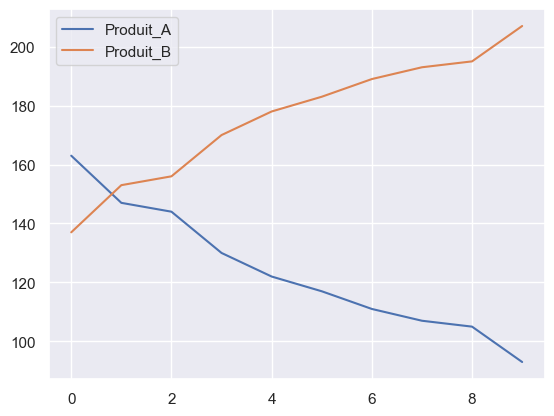

In [33]:
plt.plot(results['Produit_A'],label='Produit_A')
plt.plot(results['Produit_B'],label='Produit_B')
plt.legend()

On observe que le produit B est légèrement meilleur que le produit A sur notre population de 300 agents répartis sur les 5 profils.

Explications :
Il y a 5 profils : prix, qualité, promophiles, inertiels,équilibrés.
Il n'y a pas de promotion, ce qui ramène les promophiles à des équilibrés, donc 2/5è des agents s’intéressent plus au produit B puisque le rapport qualité prix est meilleur pour B : $ 0.5/10 > 0.7/12$. Les profils qualité vont de préférence prendre les produits de meilleure qualité (donc B). Seuls les agents prix vont s’intéresser avant tout au produit A car il est moins cher.

On relance une simulation avec des produits différents pour illustrer le fait qu'avec seulement 2 produits en concurrence directe leurs paramètres ont une grand importance. 

De plus la prise en compte des paramètres globaux (prix, qualité) peuvent faire varier l'importance du prix ou de la qualité. 

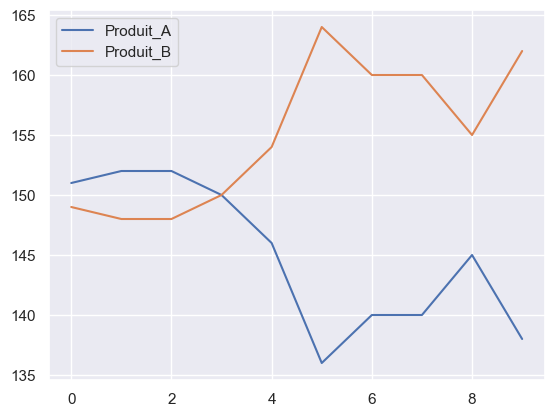

In [34]:
cat_0 = Category("catégorie 0",[Pack("Produit_A", 6, 0.6, 1), Pack("Produit_B", 24, 0.7, 1)])
sma_avec_guerre_des_prix = SMA([cat_0],300,10)
sma_avec_guerre_des_prix.initialise()
sma_avec_guerre_des_prix.run()
#On récupère les informations
results = sma_avec_guerre_des_prix.getFavorites()
results
for k in results.keys():
    plt.plot(results[k],label=k)
plt.legend()

Réalisons une nouvelle expérience sur 100 pas de temps à graine aléatoire fixée (pour la comparaison).

Maintenant nous allons réaliser une simulation un peu plus longue sans changement de prix.

In [40]:
np.random.seed(42)
#On fait la simulation
cat_0 = Category("catégorie 0",[Pack("Produit_A", 100, 0.5, 1), Pack("Produit_B", 120, 0.6, 1)])
sma_avec_guerre_des_prix = SMA([cat_0],300,100)
sma_avec_guerre_des_prix.initialise()
sma_avec_guerre_des_prix.run()
#On récupère les informations
chiffreAffaires = sma_avec_guerre_des_prix.revenues
favoris = sma_avec_guerre_des_prix.getFavorites()

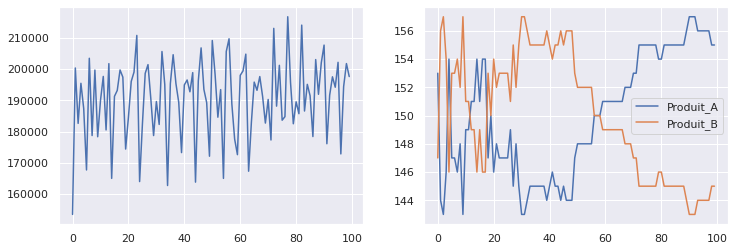

In [41]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

Nouvelle simulation avec une baisse du prix du produit A uniquement.

Un changement de prix définitif, qui n'est pas une promotion, s'effectue avec la méthode `reduce_price(pourcentage, tick d'effet, produit)` ou `raise_price(pourcentage, tick d'effet, produit)`. ce qui donne par exemple `reduce_price(20, 30, 0, 0)`.

In [42]:
np.random.seed(42)
#On fait la simulation
cat_0 = Category("catégorie 0",[Pack("Produit_A", 100, 0.5, 1), Pack("Produit_B", 120, 0.6, 1)])
sma_avec_guerre_des_prix = SMA([cat_0],300,100)
sma_avec_guerre_des_prix.initialise()
#On indique à quel moment à lieu la baisse de prix ()
sma_avec_guerre_des_prix.reduce_price(40, 30, 0, 0)
sma_avec_guerre_des_prix.run()
#On récupère les informations
chiffreAffaires = sma_avec_guerre_des_prix.revenues
favoris = sma_avec_guerre_des_prix.getFavorites()

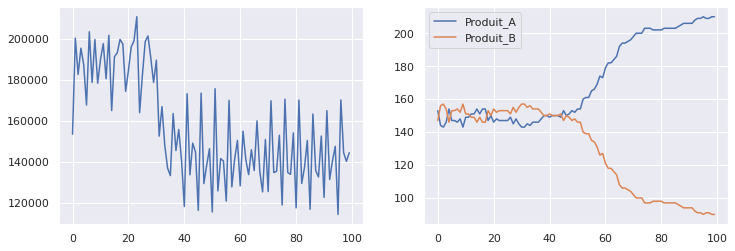

In [43]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

Finalement on réalise une simulation qui illustre la _guerre des prix_, c'est à dire que le prix du produit B baisse ce qui entraîne une baisse du prix du produit A qui entraîne à son tour une baisse du produit B etc. 
Dans une telle situation tous les produits sont "perdants". On peut l'observer par la baisse du chiffre d'affaires.

In [47]:
np.random.seed(42)
#On fait la simulation
cat_0 = Category("catégorie 0",[Pack("Produit_A", 100, 0.5, 1), Pack("Produit_B", 120, 0.6, 1)])
sma_avec_guerre_des_prix = SMA([cat_0],300,100)
sma_avec_guerre_des_prix.initialise()
#On indique à quel moment à lieu la baisse de prix ()
sma_avec_guerre_des_prix.reduce_price(20, 10, 0, 0)
sma_avec_guerre_des_prix.reduce_price(20, 20, 0, 1)
sma_avec_guerre_des_prix.reduce_price(20, 30, 0, 0)
sma_avec_guerre_des_prix.reduce_price(20, 40, 0, 1)
# environnement_price_war.reduce_price(20, 50, 0, 1)
# environnement_price_war.reduce_price(20, 60, 0, 1)
sma_avec_guerre_des_prix.run()
#On récupère les informations
chiffreAffaires = sma_avec_guerre_des_prix.revenues
favoris = sma_avec_guerre_des_prix.getFavorites()

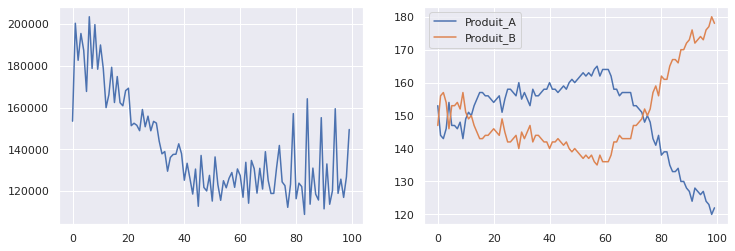

In [45]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

## Les paramètres du modèle
Le modèle dispose de 7 paramètres : prix, qualité, promophile, sat_alpha, phi, c et inertie. 
Ces paramètres sont tous des paramètres optionels qui peuvent être modifiés via la méthode `initialise()`. Par défaut leur valeur est fixe. 

`Prix, qualité, promophile, inertie` sont les paramètres que gèrent l'importance globale pour tous les agents du prix de la qualité de la promotion et de l'inertie. Ces paramètres varient selon le type de magasin. Par exemple, est-ce un magasin discount ou les prix sont plutôt bas (le paramètre prix sera élevé) ou un magasin de luxe ou le prix importe peu (le paramètre prix sera faible). 

Par exemple un prix à 1 avec les autres valeurs à 0 signifierais que les agents prennent tous uniquement en compte le prix des produits pour déterminer leurs achats. Le prix à 1 et l'inertie à 10 signifierait que tous les agents sont très inertiels et accord un peu d'importance au prix. 

`sat_alpha` correspond au paramètre de régulation de la pente de la fonction de saturation (utilisé dans le calcul de la quantité). Plus il est élevé plus la pente est douce et inversement. 

C'est la borne supérieur de cette fonction de saturation.

La fonction de saturation est utilisée dans le calcul du nombre de packs que l'agent achète. Les agents attribuent des scores selon une fonction d'utilité. Ces scores permettent aux agents de choisir le produit qu'ils vont acheter. Enfin le produit qui a été choisi est comparé à un produit de référence (mental ou réel), unique pour chaque agent. La différence est reportée dans la fonction de saturation qui vient moduler la quantité de packs achetée. Cette fonction traduit, que plus le pack est intéressant (selon les caractéristiques de l'agent) par rapport a ce qu'il a l'habitude d'acheter plus l'agent achète un grand nombre de ce pack. A l'inverse plus le produit est peu intéressant moins l'agent achète de packs.

Text(0, 0.5, 'Multiplicateur de quantité')

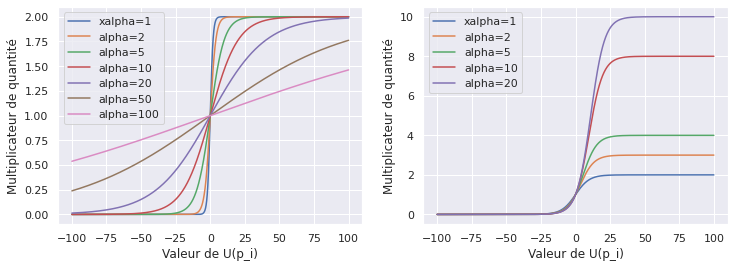

In [46]:
# Exemples de différents paramètres C et sat_alpha
# Définition de la fonction de saturation
def sat(U,alpha,c):
        x = (U)
        y = math.log(c-1)
        return c / (1 + math.exp(-x/alpha+y))

# Affichage de la fonction de saturation selon sat_alpha
fig,axs = plt.subplots(1,2,figsize=(12,4))
for alpha in [1,2,5,10,20,50,100]:
    c=2
    res = np.array(np.zeros(len(np.arange(-100,100,0.01))))
    cpt = 0
    for i in np.arange(-100,100,0.01):
        res[cpt] = sat(i,alpha,c)
        cpt+=1
    axs[0].plot(np.arange(-100,100,0.01),res)
axs[0].legend(("xalpha=1","alpha=2","alpha=5","alpha=10","alpha=20","alpha=50","alpha=100") )
axs[0].set_xlabel("Valeur de U(p_i)")
axs[0].set_ylabel("Multiplicateur de quantité")

# Affichage de la fonction de saturation selon C
for c in [2,3,4,8,10]:
    alpha = 5
    res = np.array(np.zeros(len(np.arange(-100,100,0.01))))
    cpt = 0
    for i in np.arange(-100,100,0.01):
        res[cpt] = sat(i,alpha,c)
        cpt+=1
    axs[1].plot(np.arange(-100,100,0.01),res)
axs[1].legend(("xalpha=1","alpha=2","alpha=5","alpha=10","alpha=20","alpha=50","alpha=100") )
axs[1].set_xlabel("Valeur de U(p_i)")
axs[1].set_ylabel("Multiplicateur de quantité")

Finalement Phi correspond a l'intensité de l'aversion à la perte. Phi = 0.5 équivaut à : l'impact négatif de perdre 1€ est 1.5 fois plus fort que l'impact positif de gagner 1€. Phi = 2 correspondrait à ce même ratio égal à 3 etc..

#### Simulations pour différents paramètres

Voici quelque exemples de changement de paramètres. On reprend la catégorie de produit constituée de 8 produits utilisée précédemment. 

In [56]:
sma = SMA([Ma_categorie],300,100)

Les paramètres de l'evironnement sont passés via la méthode `initialise()`
Les paramètres sont price, quality, promophile, sat_alpha, phi, c, inertia

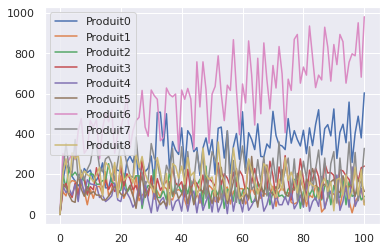

0

In [57]:
sma.initialise(inertia = 10)
sma.makePromo(0,40,(30,34),"maCategorie","Produit0")
sma.run()
sma.showPacksSales()

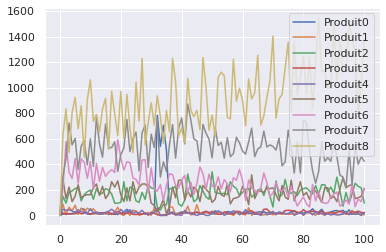

0

In [59]:
sma.initialise(inertia = 0)
sma.makePromo(0,40,(30,34),"maCategorie","Produit0")
sma.run()
sma.showPacksSales()

On voit qu'il n'y a plus de fidélisation

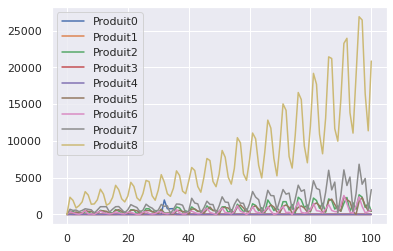

0

In [60]:
sma.initialise(price=0.5, quality=100, promophile=5, sat_alpha=1, phi=0.3, c = 2, inertia = 2)
sma.makePromo(0,40,(30,34),"maCategorie","Produit0")
sma.run()
sma.showPacksSales()

In [61]:
sma.initialise(price=2, quality=0, promophile=5, sat_alpha=100, phi=0.3, c = 2, inertia = 0)
sma.makePromo(0,40,(30,34),"maCategorie","Produit0")
sma.run()
sma.showPacksSales()

AttributeError: 'SMA' object has no attribute 'show_sales'

La qualité n'ayant plus d'impact on observe que certains produits (les plus chers) ne sont plus du tout achetés 